## Load Dataset

In [1]:
import pandas as pd
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    BartTokenizer, 
    BartForConditionalGeneration
)
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os

# Set environment variable to avoid OpenMP error
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('../../../../Amazon_dataset/customer_review_amazon_products.csv')

c:\Users\edwar\anaconda3\envs\nlp_cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset...


C:\Users\edwar\AppData\Local\Temp\ipykernel_34844\1344881572.py:21: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../../../Amazon_dataset/customer_review_amazon_products.csv')


## Take top 5 categories by number of reviews

<Axes: xlabel='name'>

) missing from font(s) DejaVu Sans.uda\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.uda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


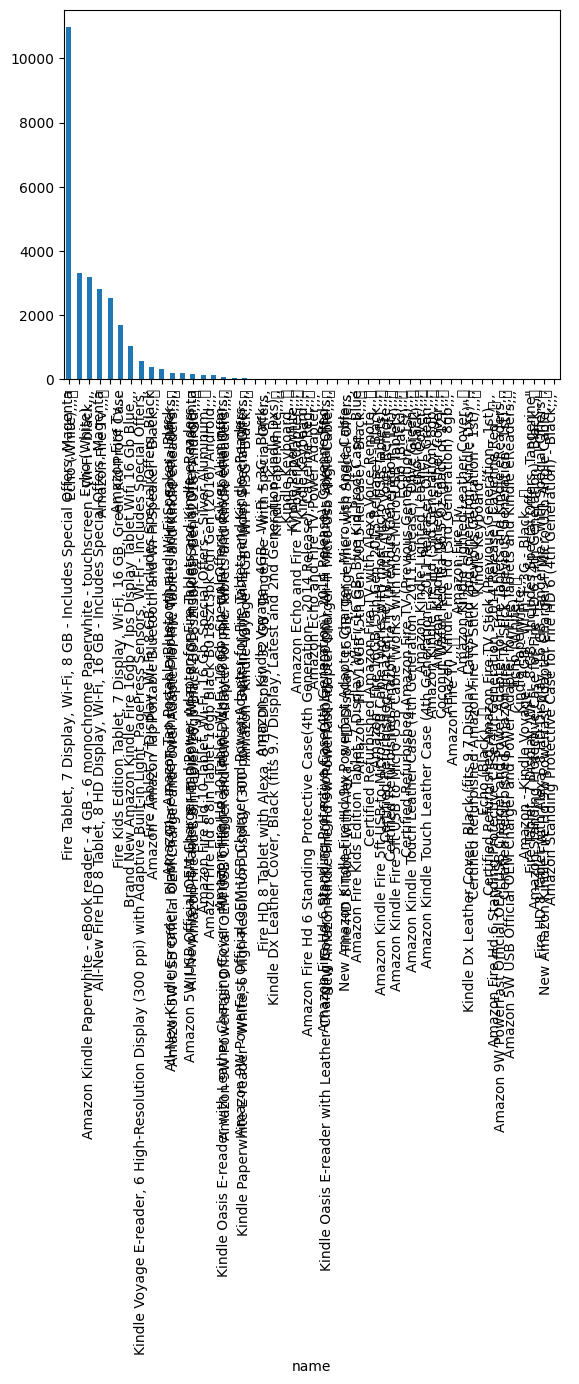

In [2]:
# Take top 5 categories by number of reviews
top_categories = df['name'].value_counts().index.tolist()
df_filtered = df[df['name'].isin(top_categories)]

#Plot the top 5 categories
df_filtered['name'].value_counts().plot(kind='bar')



In [5]:
 #Preprocesamiento básico
def preprocess_data(df):
    # Eliminar filas con valores nulos en el texto y ratings
    df = df.dropna(subset=['reviews.text', 'reviews.rating'])
    
    # Asegurarse de que los textos sean strings
    df['reviews.text'] = df['reviews.text'].astype(str)
    
    # Convertir ratings a float y eliminar valores no válidos
    df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
    df = df[df['reviews.rating'].notna()]  # Eliminar filas con ratings NaN
    
    # Convertir ratings a sentimientos
    df['sentiment'] = df['reviews.rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
    
    # Limpiar textos muy cortos o muy largos
    df = df[df['reviews.text'].str.len() > 10]  # eliminar textos muy cortos
    df = df[df['reviews.text'].str.len() < 512]  # eliminar textos muy largos
    
    # Limpiar nombres de productos
    df['name'] = df['name'].str.strip()
    
    # Verificar el resultado del preprocesamiento
    print("\nDespués del preprocesamiento:")
    print(f"Número total de reviews: {len(df)}")
    print("\nDistribución de ratings:")
    print(df['reviews.rating'].value_counts().sort_index())
    print("\nDistribución de sentimientos:")
    print(df['sentiment'].value_counts().sort_index())
    
    return df

df = preprocess_data(df)


Después del preprocesamiento:
Número total de reviews: 33506

Distribución de ratings:
reviews.rating
1.0      367
2.0      363
3.0     1404
4.0     8200
5.0    23172
Name: count, dtype: int64

Distribución de sentimientos:
sentiment
0      730
1     1404
2    31372
Name: count, dtype: int64


C:\Users\edwar\AppData\Local\Temp\ipykernel_34844\3044716604.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews.text'] = df['reviews.text'].astype(str)
C:\Users\edwar\AppData\Local\Temp\ipykernel_34844\3044716604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')


## Data Analysis- Distribution of ratings

In [6]:
# Print rating distribution
review=pd.DataFrame(df.groupby('sentiment').size().sort_values(ascending=False).rename('No of Users').reset_index())
review.head()

,sentiment,No of Users
0,2,31372
1,1,1404
2,0,730


## Balance datasets

## Loads model and tokenizer

In [7]:
# Load models
print("Loading BERT sentiment model...")
tokenizer_sentiment = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model_sentiment = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Loading BERT sentiment model...


## Sentiment Classification Model

In [8]:
# Evaluate sentiment model
"""
print("\nEvaluating Sentiment Model Performance...")
sample_size = 1000
df_sample = df_filtered.groupby('reviews.rating').apply(
    lambda x: x.sample(min(len(x), sample_size))
).reset_index(drop=True)


"""
df_sample = df

In [9]:
true_labels = []
predicted_labels = []
# Process each review for evaluation
print("Analyzing sentiments...")
for _, row in tqdm(df_sample.iterrows()):
    if isinstance(row['reviews.text'], str):
        # Get true sentiment from rating
        if row['reviews.rating'] >= 4:
            true_sentiment = "positive"
        elif row['reviews.rating'] <= 2:
            true_sentiment = "negative"
        else:
            true_sentiment = "neutral"
        
        # Get predicted sentiment
        inputs = tokenizer_sentiment(row['reviews.text'], return_tensors="pt", truncation=True, max_length=512)
        outputs = model_sentiment(**inputs)
        sentiment_score = torch.argmax(outputs.logits).item() + 1
        
        # Convert score to sentiment
        if sentiment_score >= 4:
            predicted_sentiment = "positive"
        elif sentiment_score <= 2:
            predicted_sentiment = "negative"
        else:
            predicted_sentiment = "neutral"
        
        true_labels.append(true_sentiment)
        predicted_labels.append(predicted_sentiment)
        
    # Generate and save evaluation results
report = classification_report(
    true_labels,
    predicted_labels,
    labels=['negative', 'neutral', 'positive'],
    digits=3
)


Analyzing sentiments...


33506it [21:50, 25.57it/s]


In [10]:
# Save evaluation results
with open('BERT_sentiment_evaluation_results_ALL_DATASET.txt', 'w') as f:
    f.write("Sentiment Classification Model Evaluation\n")
    f.write("=" * 40 + "\n\n")
    f.write(str(report))

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    negative      0.395     0.755     0.518       730
     neutral      0.288     0.419     0.341      1404
    positive      0.980     0.939     0.959     31372

    accuracy                          0.913     33506
   macro avg      0.554     0.704     0.606     33506
weighted avg      0.938     0.913     0.924     33506



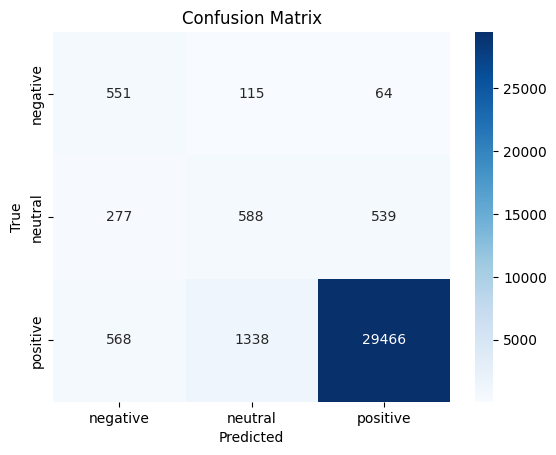

In [11]:
## Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
